In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms,utils
from torch.utils.data import Dataset,DataLoader
import scipy.io as io
import os
import numpy as np
import matplotlib.pyplot as plt
import time

#重新定义Dataset
class MyDataset(Dataset):
    def __init__(self,path):
        data = np.loadtxt(path,delimiter=',',dtype=np.float32)
        self.data_x = torch.from_numpy(data[:,0:-1]).reshape(data.shape[0],1,data.shape[1]-1)#取数据除了最后一列
        self.data_y = torch.from_numpy(data[:,-1].astype(np.int64))#取数据最后一列，并将浮点型转换为长整形
        self.len = data.shape[0]
        #self.minmax_normalize()
        
    def __getitem__(self,index):
        return self.data_x[index],self.data_y[index]
    
    def __len__(self):
        return self.len
    def minmax_normalize(self):
        
        '''return minmax normalize dataset'''
        for index in range(self.len):
            self.data_x[index] = (self.data_x[index] - self.data_x[index].min())/(
            self.data_x[index].max() - self.data_x[index].min())
              
        

    
trainset= MyDataset(path='trainset.csv')#训练集路径
testset = MyDataset(path='testset.csv')#测试集路径

train_loader = DataLoader(dataset=trainset,
                         batch_size=5,
                         shuffle=True)
test_loader = DataLoader(dataset=testset,
                        batch_size=5,
                        shuffle=False)
#train_loder 和 test_loader 可以查看数据的size是否正确
for epoch in range(2):
    for i,data in enumerate(train_loader):
        inputs,labels =data
        
        print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())

epoch： 0 的第 0 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 1 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 2 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 3 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 4 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 5 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 6 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 7 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 8 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 9 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 10 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 11 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 12 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 13 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 0 的第 14 个inputs torch.S

epoch： 1 的第 41 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 42 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 43 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 44 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 45 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 46 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 47 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 48 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 49 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 50 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 51 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 52 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 53 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 54 个inputs torch.Size([5, 1, 224]) labels torch.Size([5])
epoch： 1 的第 55 个inpu

In [2]:

#定义网络
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.conv1=nn.Conv1d(1,16,kernel_size=4,stride=2,padding=1)  #shape (1*1*224)-->(16*1*112)
        self.bn1 =nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16,32,kernel_size=4,stride=2,padding=1) #(16*1*112)-->(32*1*56)
        self.bn2 =nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32,64,kernel_size=4,stride=2,padding=1) #(32*1*56)-->(64*1*28)
        self.bn3 =nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64,128,kernel_size=4,stride=2,padding=1) #(64*1*28)-->(128*1*14)
        self.bn4 =nn.BatchNorm1d(128)
        
        #self.conv5 =nn.Conv1d(128,256,kernel_size=4,stride=2,padding=1)#(128*1*14)-->(256*1*7)
        #self.bn5=nn.BatchNorm1d(256)
        
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*7,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,4)
       
    def forward(self, x):
        
        x=F.relu(self.conv1(x))
        x=self.bn1(x)
        x=F.relu(self.conv2(x))
        x=self.bn2(x)
        x=F.relu(self.conv3(x))
        x=self.bn3(x)
        x=F.relu(self.conv4(x))
        x=self.bn4(x)
        #x=F.relu(self.conv5(x))
        #x=self.bn5(x)
        
        x=x.view(-1,128*14)
        x=F.relu(self.fc1(x))
       # x=self.drop(x)
        x=F.relu(self.fc2(x))
       # x=self.drop(x)
        x=F.relu(self.fc3(x))
        #x=self.drop(x)
        x=F.relu(self.fc4(x))
        self.feature =x
        #x=self.drop(x)
        x=self.fc5(x)
    
     
        #x = x.squeeze(-1)
        return x
    def weight_init(self):
        for m in model.modules():
            if isinstance(m,nn.Conv1d):
                nn.init.normal(m.weight.data)
                nn.init.xavier_normal(m.weight.data)
                nn.init.kaiming_normal(m.weight.data)#卷积层参数初始化
                m.bias.data.fill_(0)
            elif isinstance(m,nn.Linear):
                m.weight.data.normal_()#全连接层参数初始化
model = MyNet()
#model.weight_init()
#model.apply(weights_init)
print(model)

MyNet(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1792, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999))
#optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
start = time.time()
#开始训练
train_losses=[]
epoch_list=[]
train_accuracy_list=[]
test_losses=[]
test_accuracy_list=[]
for epoch in range(100): #epoch在100至300之间
    
    train_loss = 0.
    test_loss = 0.
    train_num_correct=0
    test_num_correct=0
    for i, data in enumerate(train_loader):
        
        inputs,labels =data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        pred =outputs.argmax(dim=1)
        train_num_correct += torch.eq(pred,labels).sum().float().item()
    #min_train_num_correct=0
    #if train_num_correct>=min_train_num_correct:
       #min_rain_num_correct=train_num_correct
        out_feature =model.feature

    with torch.no_grad():
        outputs_test_list=[]
        for i,data in enumerate(test_loader):
            inputs_test,label_test= data
            outputs_test=model(inputs_test)
           # outputs_test_list.append(outputs_test.numpy())
            loss_test =criterion(outputs_test,label_test)
             
            test_loss+=loss_test.item()
            pred_test =outputs_test.argmax(dim=1)
            test_num_correct+=torch.eq(pred_test,label_test).sum().float().item()
        
        
    print("Epoch: {}\t Train Loss: {:.6f}\t Train Acc: {:.6f}\t Test Loss: {:.6f}\t Test Acc: {:.6f}".format(epoch,train_loss/len(train_loader),
                                                                                                                   train_num_correct/len(train_loader.dataset),test_loss/len(test_loader),
                                                                                                                   test_num_correct/len(test_loader.dataset)))
    #print("Epoch: {}\t Train Loss: {:.6f}\t \t Test Loss: {:.6f}".format(epoch,train_loss/len(train_loader),test_loss/len(test_loader)))
    
          
    train_losses.append(train_loss/len(train_loader))
    train_accuracy_list.append(train_num_correct/len(train_loader.dataset))
    test_losses.append(test_loss/len(test_loader))
    test_accuracy_list.append(test_num_correct/len(test_loader.dataset))
    epoch_list.append(epoch)

print("finished training")           
print('time = %2dm:%2ds' % ((time.time() - start)//60, (time.time()-start)%60))

Epoch: 0	 Train Loss: 1.028700	 Train Acc: 0.469167	 Test Loss: 0.984541	 Test Acc: 0.492500
Epoch: 1	 Train Loss: 0.910721	 Train Acc: 0.529167	 Test Loss: 0.886068	 Test Acc: 0.505000
Epoch: 2	 Train Loss: 0.874066	 Train Acc: 0.558333	 Test Loss: 0.904487	 Test Acc: 0.512500
Epoch: 3	 Train Loss: 0.794020	 Train Acc: 0.590000	 Test Loss: 0.789513	 Test Acc: 0.592500
Epoch: 4	 Train Loss: 0.724410	 Train Acc: 0.664167	 Test Loss: 0.816978	 Test Acc: 0.617500
Epoch: 5	 Train Loss: 0.658299	 Train Acc: 0.685000	 Test Loss: 0.724285	 Test Acc: 0.622500
Epoch: 6	 Train Loss: 0.655206	 Train Acc: 0.699167	 Test Loss: 1.693055	 Test Acc: 0.460000
Epoch: 7	 Train Loss: 0.597264	 Train Acc: 0.728333	 Test Loss: 0.574309	 Test Acc: 0.710000
Epoch: 8	 Train Loss: 0.563138	 Train Acc: 0.754167	 Test Loss: 0.665655	 Test Acc: 0.682500
Epoch: 9	 Train Loss: 0.575491	 Train Acc: 0.730000	 Test Loss: 1.737866	 Test Acc: 0.480000
Epoch: 10	 Train Loss: 0.613722	 Train Acc: 0.732500	 Test Loss: 0.629

Epoch: 88	 Train Loss: 0.140684	 Train Acc: 0.948333	 Test Loss: 0.123687	 Test Acc: 0.947500
Epoch: 89	 Train Loss: 0.107862	 Train Acc: 0.965000	 Test Loss: 0.122719	 Test Acc: 0.950000
Epoch: 90	 Train Loss: 0.091508	 Train Acc: 0.973333	 Test Loss: 0.174271	 Test Acc: 0.932500
Epoch: 91	 Train Loss: 0.071544	 Train Acc: 0.975000	 Test Loss: 0.157626	 Test Acc: 0.967500
Epoch: 92	 Train Loss: 0.134576	 Train Acc: 0.958333	 Test Loss: 0.163791	 Test Acc: 0.940000
Epoch: 93	 Train Loss: 0.250244	 Train Acc: 0.935833	 Test Loss: 0.261925	 Test Acc: 0.890000
Epoch: 94	 Train Loss: 0.116935	 Train Acc: 0.961667	 Test Loss: 0.195694	 Test Acc: 0.950000
Epoch: 95	 Train Loss: 0.120612	 Train Acc: 0.962500	 Test Loss: 0.080583	 Test Acc: 0.967500
Epoch: 96	 Train Loss: 0.072831	 Train Acc: 0.973333	 Test Loss: 0.105072	 Test Acc: 0.957500
Epoch: 97	 Train Loss: 0.109798	 Train Acc: 0.964167	 Test Loss: 0.174947	 Test Acc: 0.927500
Epoch: 98	 Train Loss: 0.103254	 Train Acc: 0.968333	 Test L

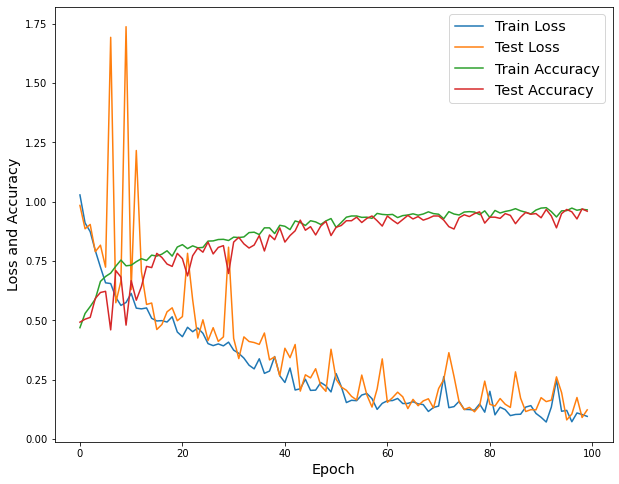

In [5]:
#绘制loss和accuracy曲线
plt.figure(figsize=(10,8))
plt.plot(epoch_list,train_losses)
plt.plot(epoch_list,test_losses)
plt.xlabel('Epoch',fontsize="x-large")
plt.ylabel('Loss and Accuracy',fontsize='x-large')
plt.plot(epoch_list,train_accuracy_list)
plt.plot(epoch_list,test_accuracy_list)
plt.legend(['Train Loss','Test Loss','Train Accuracy','Test Accuracy'],fontsize="x-large",loc='upper right')
#plt.savefig('loss and accuracy_cv4.png',bbox_inches='tight',dpi=300,pad_inches=0.1)
plt.show()